
📊 MSE: 2322.8604
📈 R² Score: 0.4975

📋 特徵重要性：
稅前淨利（淨損）        0.014843
營業利益（損失）        0.019167
營收成長_年季平均(%)    0.020402
營業毛利（毛損）        0.023167
營業外收入及支出        0.036251
營業收入            0.101710
基本每股盈餘（元）       0.784460
dtype: float64


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2251125464.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


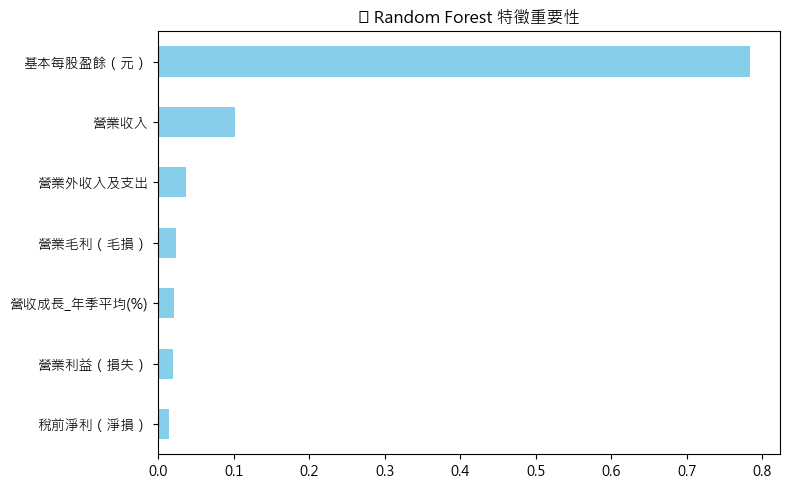


🔁 Permutation Importance：
營收成長_年季平均(%)    0.034788
營業利益（損失）        0.035644
營業毛利（毛損）        0.040333
營業外收入及支出        0.063357
稅前淨利（淨損）        0.140652
營業收入            0.195854
基本每股盈餘（元）       0.993988
dtype: float64


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2251125464.py:107: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


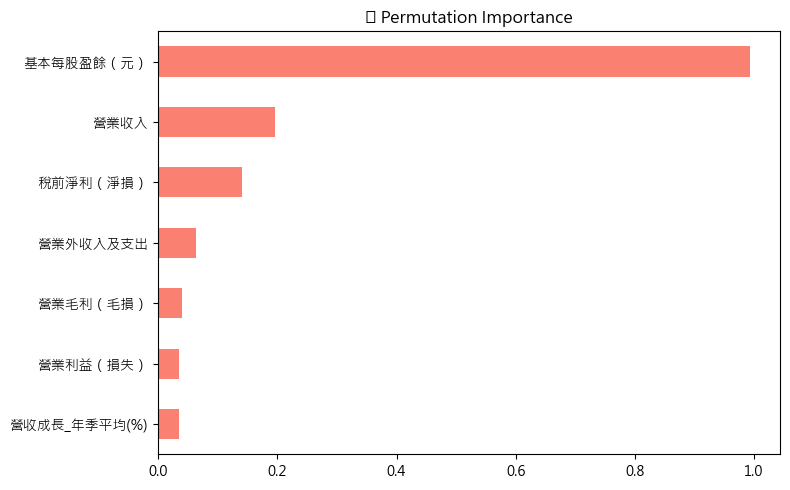

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2251125464.py:114: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


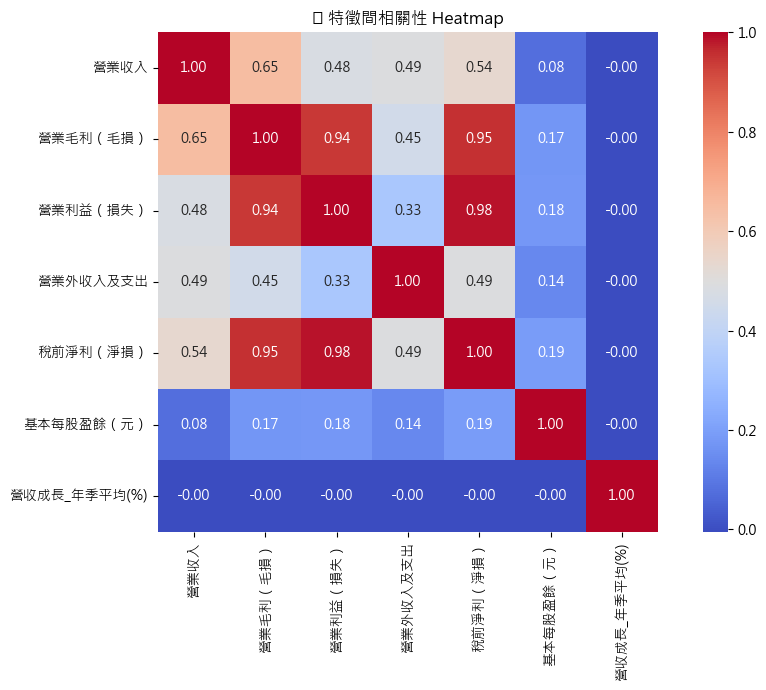


📈 Partial Dependence Plot：


<Figure size 1000x600 with 0 Axes>

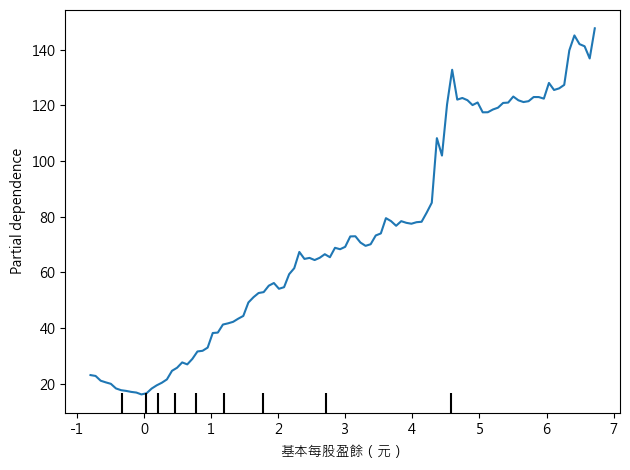

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ===== 設定中文字型（Windows） =====
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# ===== Step 1：讀取與合併資料 =====
df_fin_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_fin_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

# 合併上市與上櫃財報
df_fin = pd.concat([df_fin_sii, df_fin_otc], ignore_index=True)

# 統一 key 欄位
df_fin["公司代號"] = df_fin["公司代號"].astype(str).str.strip()
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()

df_price["公司代號"] = df_price["公司代號"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()

df_revenue["公司代號"] = df_revenue["公司代號"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

# 合併成一份大表
df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

# 建立 EPS 別名（只是為了之後圖上使用）
df["EPS"] = df["基本每股盈餘（元）"]

# ===== Step 2：設定特徵與目標 =====
target = "季均價"

feature_cols = [
    "營業收入",
    "營業毛利（毛損）",
    "營業利益（損失）",
    "營業外收入及支出",
    "稅前淨利（淨損）",
    "營業毛利/營業收入",
    "營業利益/營業收入",
    "營業外收入支出/稅前淨利",
    "基本每股盈餘（元）",  # 從財報來
    "營收成長_年季平均(%)"  # 從營收表來
]

# 移除不存在欄位（安全檢查）
feature_cols = [col for col in feature_cols if col in df.columns]

# 處理特徵與目標
X = df[feature_cols].replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(df[target], errors='coerce')

# ===== Step 3：補值 =====
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

# ===== Step 4：切分訓練與測試資料 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# ===== Step 5：建立模型 =====
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ===== Step 6：模型評估 =====
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 MSE: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===== Step 7：特徵重要性（含為 0 的） =====
feat_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=True)

print("\n📋 特徵重要性：")
print(feat_imp)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind="barh", color="skyblue")
plt.title("📊 Random Forest 特徵重要性")
plt.tight_layout()
plt.show()

# ===== Step 8：Permutation Importance =====
perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.Series(perm_result.importances_mean, index=feature_cols).sort_values()

print("\n🔁 Permutation Importance：")
print(perm_importance)

plt.figure(figsize=(8, 5))
perm_importance.plot(kind="barh", color="salmon")
plt.title("🔁 Permutation Importance")
plt.tight_layout()
plt.show()

# ===== Step 9：Heatmap =====
plt.figure(figsize=(10, 7))
sns.heatmap(X_imputed.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("🧮 特徵間相關性 Heatmap")
plt.tight_layout()
plt.show()

# ===== Step 10：偏依圖（Partial Dependence）=====
features_to_plot = [col for col in ["營業毛利/營業收入", "營業利益/營業收入", "基本每股盈餘（元）"] if col in X_imputed.columns]

print("\n📈 Partial Dependence Plot：")
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_imputed, features_to_plot, kind='average')
plt.tight_layout()
plt.show()



📊 MSE: 2322.8604
📈 R² Score: 0.4975


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\222174254.py:77: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


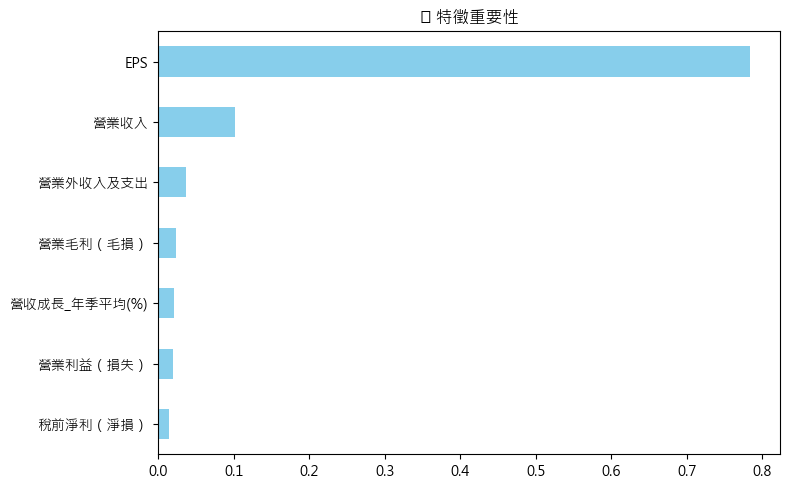

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\222174254.py:86: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


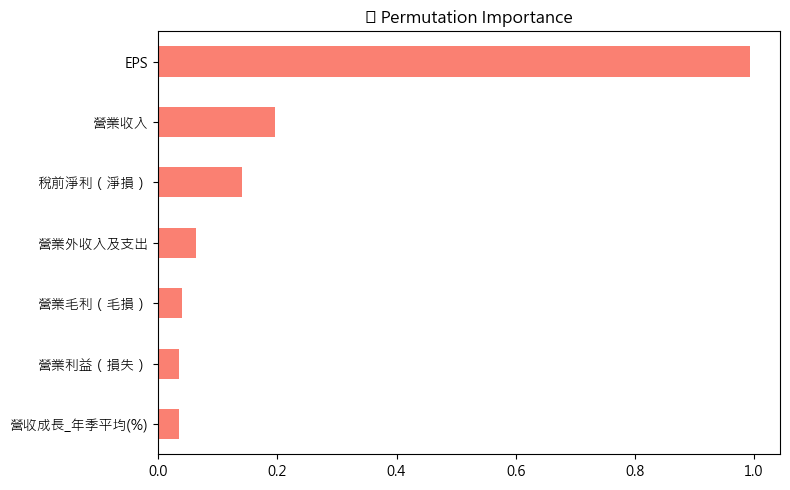

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\222174254.py:93: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


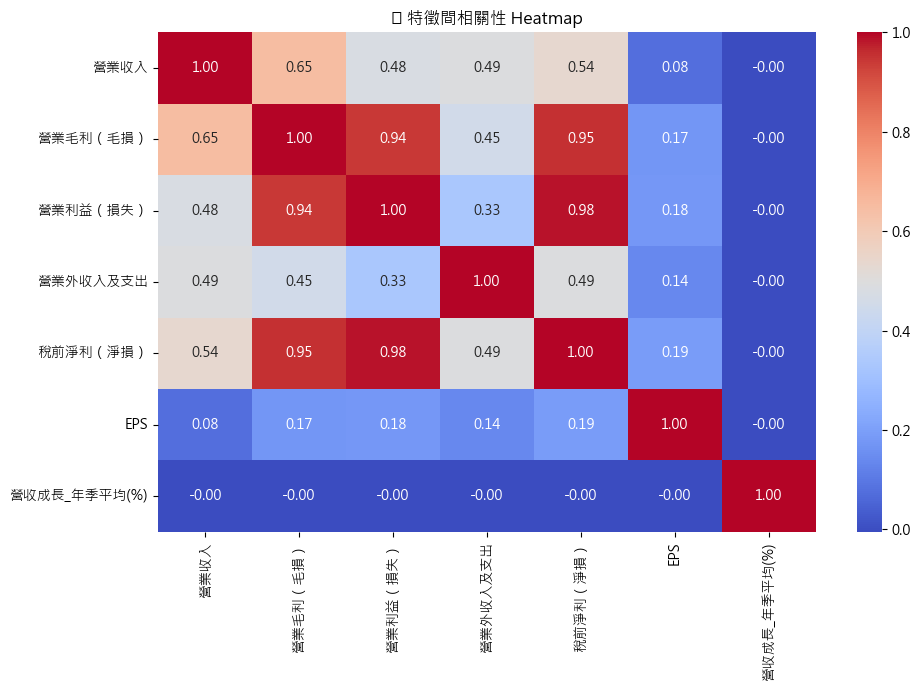

<Figure size 1000x600 with 0 Axes>

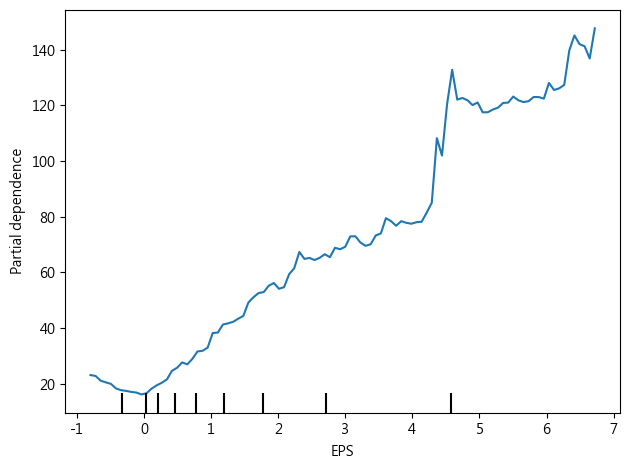

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\222174254.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


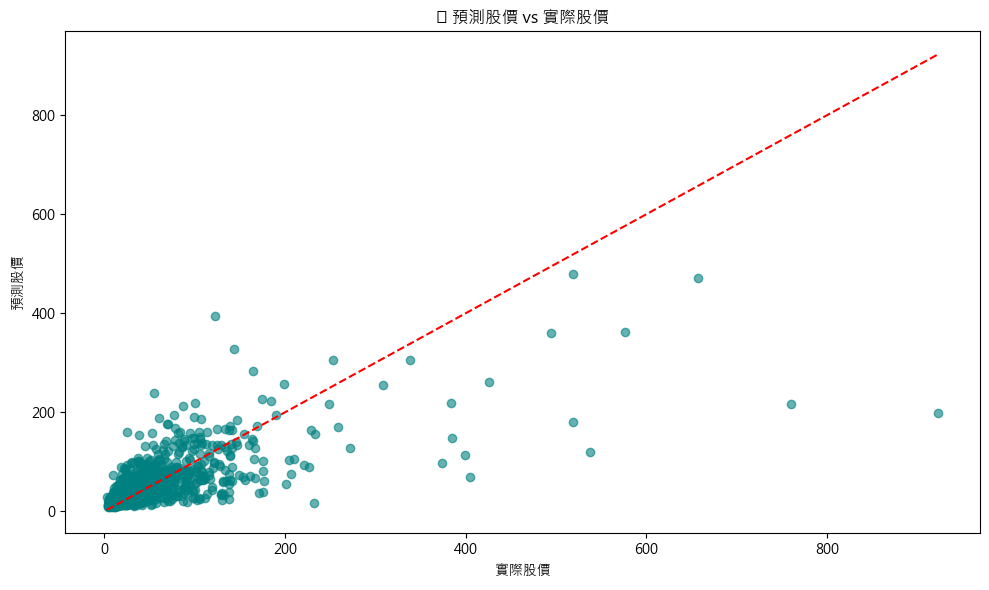

KeyError: "['公司名稱'] not in index"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# ========== Step 1：讀取與合併資料 ==========
df_fin_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_fin_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

df_fin = pd.concat([df_fin_sii, df_fin_otc], ignore_index=True)

# 建立主鍵欄位
df_fin["公司代號"] = df_fin["公司代號"].astype(str).str.strip()
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()
df_price["公司代號"] = df_price["公司代號"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()
df_revenue["公司代號"] = df_revenue["公司代號"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

# 合併三份資料
df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

# 補上 EPS 欄位別名
df["EPS"] = df["基本每股盈餘（元）"]

# ========== Step 2：設定特徵與目標 ==========
target = "季均價"
feature_cols = [
    "營業收入", "營業毛利（毛損）", "營業利益（損失）",
    "營業外收入及支出", "稅前淨利（淨損）",
    "營業毛利/營業收入", "營業利益/營業收入", "營業外收入支出/稅前淨利",
    "EPS", "營收成長_年季平均(%)"
]

feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(df[target], errors='coerce')

# ========== Step 3：補值 ==========
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

# ========== Step 4：切分資料 ==========
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_imputed, y, df.copy(), test_size=0.2, random_state=42
)

# ========== Step 5：建模 ==========
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ========== Step 6：預測與評估 ==========
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 MSE: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ========== Step 7：特徵重要性 ==========
feat_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(8, 5))
feat_imp.plot(kind="barh", color="skyblue")
plt.title("📊 特徵重要性")
plt.tight_layout()
plt.show()

# ========== Step 8：Permutation Importance ==========
perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_imp = pd.Series(perm_result.importances_mean, index=feature_cols).sort_values()
plt.figure(figsize=(8, 5))
perm_imp.plot(kind="barh", color="salmon")
plt.title("🔁 Permutation Importance")
plt.tight_layout()
plt.show()

# ========== Step 9：Heatmap ==========
plt.figure(figsize=(10, 7))
sns.heatmap(X_imputed.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("🧮 特徵間相關性 Heatmap")
plt.tight_layout()
plt.show()

# ========== Step 10：Partial Dependence Plot ==========
features_to_plot = [col for col in ["營業毛利/營業收入", "營業利益/營業收入", "EPS"] if col in X_imputed.columns]
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_imputed, features_to_plot, kind='average')
plt.tight_layout()
plt.show()

# ========== Step 11：預測 vs 實際 圖表 ==========
df_test["預測股價"] = y_pred
df_test["實際股價"] = y_test.values
df_test["誤差"] = df_test["預測股價"] - df_test["實際股價"]
df_test["誤差率(%)"] = (df_test["誤差"] / df_test["實際股價"] * 100).round(2)

plt.figure(figsize=(10, 6))
plt.scatter(df_test["實際股價"], df_test["預測股價"], alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("實際股價")
plt.ylabel("預測股價")
plt.title("📈 預測股價 vs 實際股價")
plt.tight_layout()
plt.show()

# ========== Step 12：匯出預測結果 ==========
df_test[["公司代號", "公司名稱", "year_quarter", "產業別",
         "實際股價", "預測股價", "誤差", "誤差率(%)"]] \
    .sort_values(by="誤差率(%)", ascending=False) \
    .to_csv("預測股價結果.csv", index=False, encoding="utf-8-sig")
print("✅ 預測結果已匯出：預測股價結果.csv")

# ========== Step 13：找出誤差較大的公司 ==========
large_error = df_test[np.abs(df_test["誤差率(%)"]) > 10]
print(f"\n🚨 預測誤差 > 10% 的樣本數：{len(large_error)}")
print(large_error[["公司代號", "公司名稱", "year_quarter", "產業別", "誤差率(%)"]])


In [5]:
print(df.columns.tolist())

['公司代號', '公司名稱_x', '營業收入', '營業毛利（毛損）', '營業利益（損失）', '營業外收入及支出', '稅前淨利（淨損）', '基本每股盈餘（元）', '毛利率', '營益率', '業外稅前率', '年季', 'year_quarter', '季均價', '公司名稱_y', '產業別', '營業收入-當月營收', '營收成長_年季平均(%)', 'EPS']



📊 MSE: 2322.8604
📈 R² Score: 0.4975


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2880870357.py:79: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


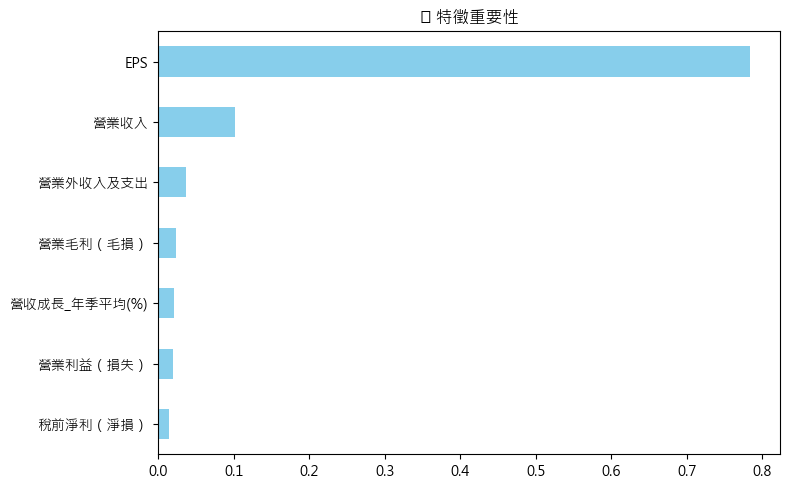

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2880870357.py:88: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


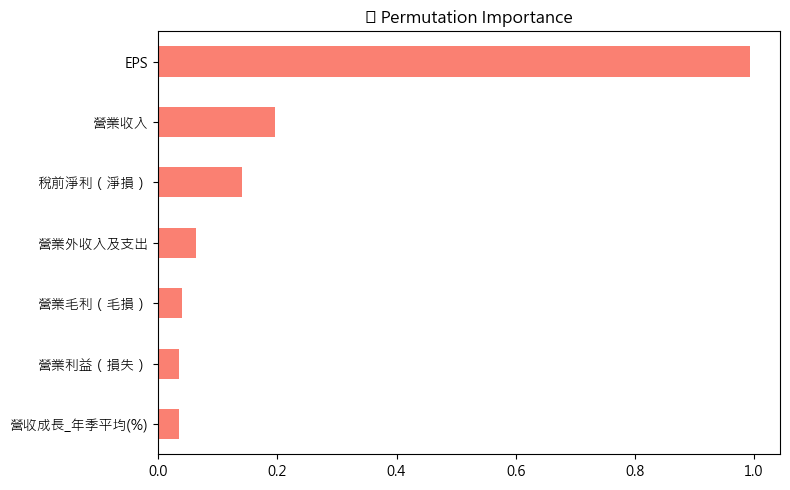

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2880870357.py:95: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


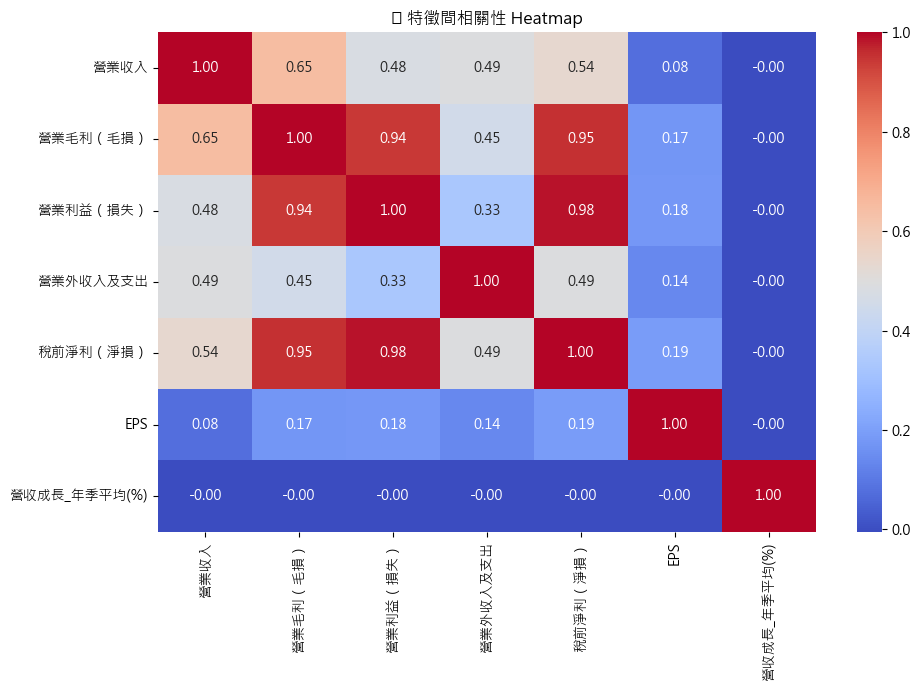

<Figure size 1000x600 with 0 Axes>

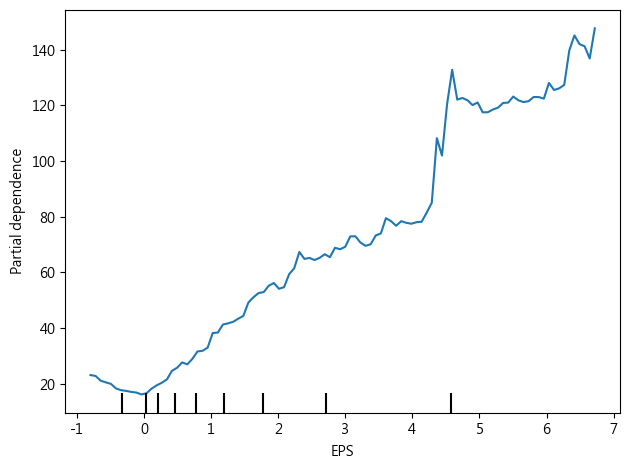

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2880870357.py:117: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


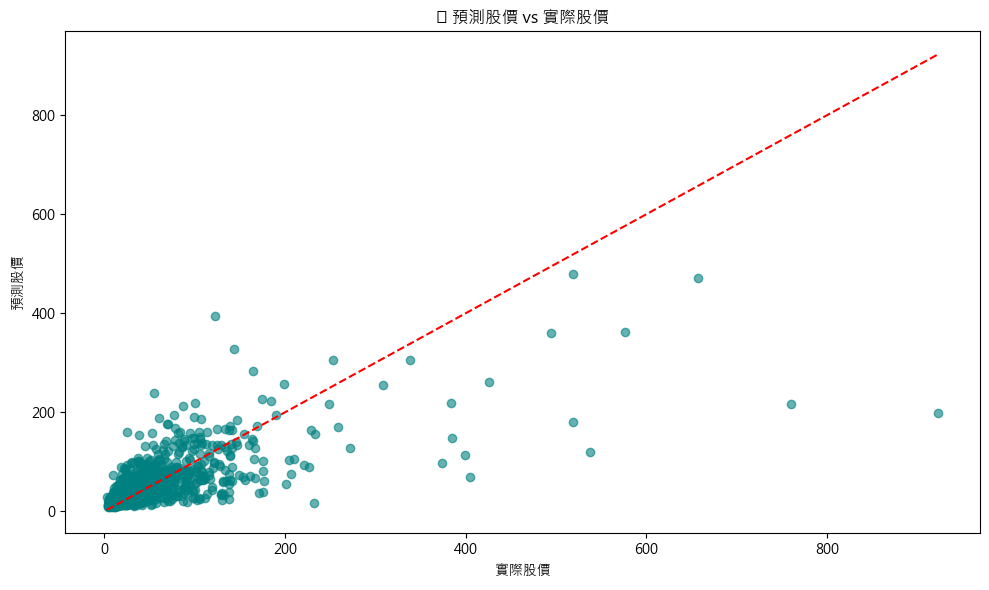

✅ 預測結果已匯出：預測股價結果.csv

🚨 預測誤差 > 10% 的樣本數：1100
      公司代號 公司名稱 year_quarter     產業別  誤差率(%)
3158  1437  勤益控       2018Q2      其他  151.32
1345  2484   希華       2017Q2  電子零組件業   43.59
5916  2642  宅配通       2019Q4     航運業  102.11
5533  2024   志聯       2019Q3    鋼鐵工業   74.67
6215  5269   祥碩       2020Q1    半導體業  -71.39
...    ...  ...          ...     ...     ...
2746  2367   燿華       2018Q1  電子零組件業   71.14
2232  2329   華泰       2017Q4    半導體業   27.72
106   3052   夆典       2016Q2     NaN  119.12
5030  1517   利奇       2019Q2    電機機械   69.52
2704  2102   泰豐       2018Q1    橡膠工業  -16.08

[1100 rows x 5 columns]


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# ========== Step 1：讀取與合併資料 ==========
df_fin_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_fin_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

df_fin = pd.concat([df_fin_sii, df_fin_otc], ignore_index=True)

# 統一主鍵欄位
df_fin["公司代號"] = df_fin["公司代號"].astype(str).str.strip()
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()
df_price["公司代號"] = df_price["公司代號"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()
df_revenue["公司代號"] = df_revenue["公司代號"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

# 合併資料
df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

# ✅ 統一公司名稱欄位，處理 _x / _y 衝突
df["公司名稱"] = df["公司名稱_x"]
df.drop(columns=["公司名稱_x", "公司名稱_y"], inplace=True, errors="ignore")

# ✅ 加入 EPS 欄位別名
df["EPS"] = df["基本每股盈餘（元）"]

# ========== Step 2：設定特徵與目標 ==========
target = "季均價"
feature_cols = [
    "營業收入", "營業毛利（毛損）", "營業利益（損失）",
    "營業外收入及支出", "稅前淨利（淨損）",
    "營業毛利/營業收入", "營業利益/營業收入", "營業外收入支出/稅前淨利",
    "EPS", "營收成長_年季平均(%)"
]
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(df[target], errors='coerce')

# ========== Step 3：補值 ==========
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

# ========== Step 4：切分資料 ==========
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_imputed, y, df.copy(), test_size=0.2, random_state=42
)

# ========== Step 5：建模 ==========
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ========== Step 6：預測與評估 ==========
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n📊 MSE: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ========== Step 7：特徵重要性 ==========
feat_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(8, 5))
feat_imp.plot(kind="barh", color="skyblue")
plt.title("📊 特徵重要性")
plt.tight_layout()
plt.show()

# ========== Step 8：Permutation Importance ==========
perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_imp = pd.Series(perm_result.importances_mean, index=feature_cols).sort_values()
plt.figure(figsize=(8, 5))
perm_imp.plot(kind="barh", color="salmon")
plt.title("🔁 Permutation Importance")
plt.tight_layout()
plt.show()

# ========== Step 9：Heatmap ==========
plt.figure(figsize=(10, 7))
sns.heatmap(X_imputed.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("🧮 特徵間相關性 Heatmap")
plt.tight_layout()
plt.show()

# ========== Step 10：Partial Dependence Plot ==========
features_to_plot = [col for col in ["營業毛利/營業收入", "營業利益/營業收入", "EPS"] if col in X_imputed.columns]
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_imputed, features_to_plot, kind='average')
plt.tight_layout()
plt.show()

# ========== Step 11：預測 vs 實際 圖表 ==========
df_test["預測股價"] = y_pred
df_test["實際股價"] = y_test.values
df_test["誤差"] = df_test["預測股價"] - df_test["實際股價"]
df_test["誤差率(%)"] = (df_test["誤差"] / df_test["實際股價"] * 100).round(2)

plt.figure(figsize=(10, 6))
plt.scatter(df_test["實際股價"], df_test["預測股價"], alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("實際股價")
plt.ylabel("預測股價")
plt.title("📈 預測股價 vs 實際股價")
plt.tight_layout()
plt.show()

# ========== Step 12：匯出預測結果 ==========
export_cols = [col for col in ["公司代號", "公司名稱", "year_quarter", "產業別",
                               "實際股價", "預測股價", "誤差", "誤差率(%)"]
               if col in df_test.columns]

df_test[export_cols] \
    .sort_values(by="誤差率(%)", ascending=False) \
    .to_csv("預測股價結果.csv", index=False, encoding="utf-8-sig")
print("✅ 預測結果已匯出：預測股價結果.csv")

# ========== Step 13：誤差大樣本報告 ==========
large_error = df_test[np.abs(df_test["誤差率(%)"]) > 10]
print(f"\n🚨 預測誤差 > 10% 的樣本數：{len(large_error)}")
if not large_error.empty:
    print(large_error[["公司代號", "公司名稱", "year_quarter", "產業別", "誤差率(%)"]])
else:
    print("✅ 所有預測樣本誤差都在 10% 以內")


In [11]:
from sklearn.metrics import r2_score, mean_squared_error

grouped = df_test.groupby("產業別")
results = []

for name, group in grouped:
    if group.shape[0] < 5:
        continue  # 太少不具參考性

    r2 = r2_score(group["實際股價"], group["預測股價"])
    mse = mean_squared_error(group["實際股價"], group["預測股價"])
    results.append({
        "產業別": name,
        "樣本數": group.shape[0],
        "MSE": round(mse, 2),
        "R²": round(r2, 4)
    })

df_eval_by_industry = pd.DataFrame(results).sort_values(by="樣本數", ascending=False)
print("📊 各產業模型表現：")
print(df_eval_by_industry)


📊 各產業模型表現：
         產業別  樣本數       MSE       R²
26    電子零組件業  137   2215.89   0.0717
4       半導體業   98  11638.53   0.4044
7       建材營造   82    741.09  -4.4451
0        光電業   65   1168.20   0.5733
28  電腦及週邊設備業   64   1864.01   0.3790
27      電機機械   60   3017.51   0.6403
2      其他電子業   55   3852.41   0.7659
14      紡織纖維   50   2466.23   0.3005
20     通信網路業   49    881.95   0.4816
1         其他   47   1630.59  -0.2722
23      鋼鐵工業   38    509.19  -0.1212
11      汽車工業   36   3430.50   0.4503
5       塑膠工業   32    327.14   0.5758
3       化學工業   32    486.34   0.7184
16       航運業   29    374.12  -2.4642
25     電子通路業   23    727.71   0.0655
13     生技醫療業   23   1135.16   0.5663
29      食品工業   22    549.54   0.5855
17      觀光餐旅   22    679.91   0.6236
9       橡膠工業   19    384.17  -0.1236
18      貿易百貨   16   1237.53   0.0765
24      電器電纜   16    525.14   0.2831
12     油電燃氣業   15    214.72   0.7289
10      水泥工業   13    367.46  -1.2745
22      運動休閒   12   4889.86  -0.3666
8       數位雲端   10   3461.96

📊 MSE（均方誤差）: 2249.8324
📈 R² Score（解釋力）: 0.5133

🔁 Permutation Importance：
營業利益（損失）        0.016244
業外稅前率           0.019029
營業外收入及支出        0.019954
營收成長_年季平均(%)    0.031662
營益率             0.035992
稅前淨利（淨損）        0.040316
營業收入            0.044615
營業毛利（毛損）        0.045189
毛利率             0.186452
EPS             1.039132
dtype: float64


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\1207247677.py:101: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


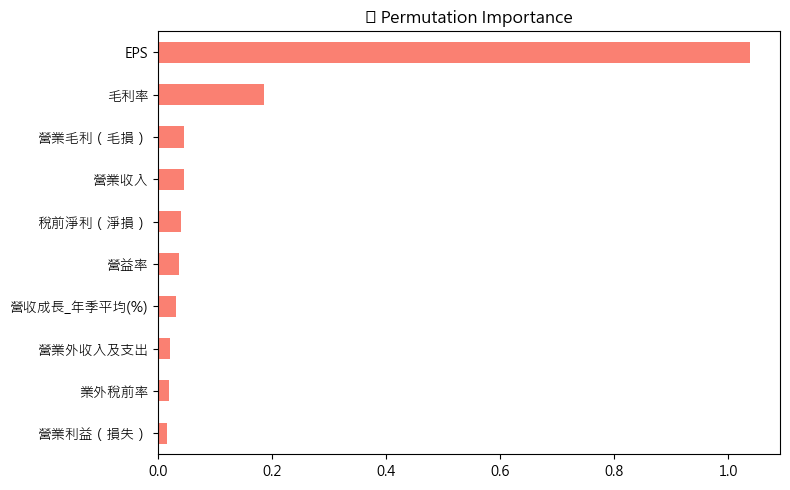

🧠 計算 SHAP 值中...


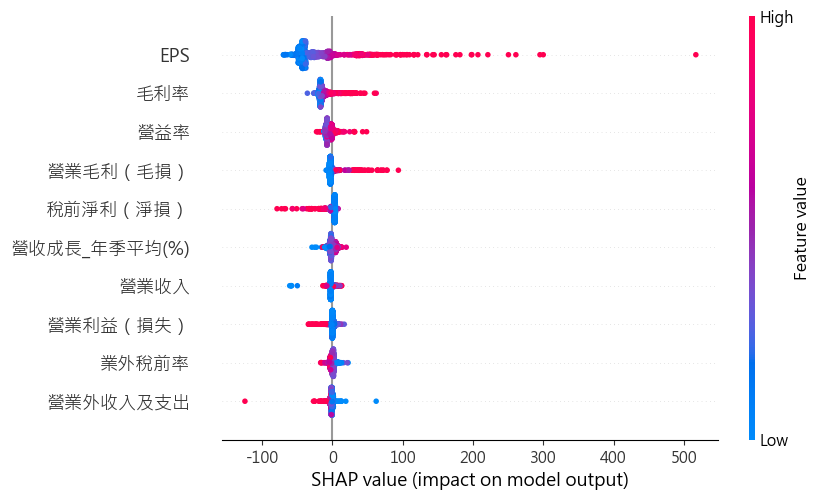

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\1207247677.py:111: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


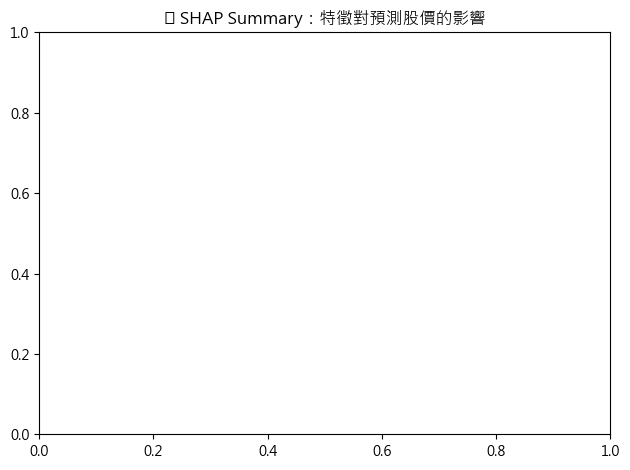

c:\Users\Robby1206\anaconda3\Lib\site-packages\shap\plots\_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)



🔍 SHAP 單一樣本解釋（第 0 筆）


c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


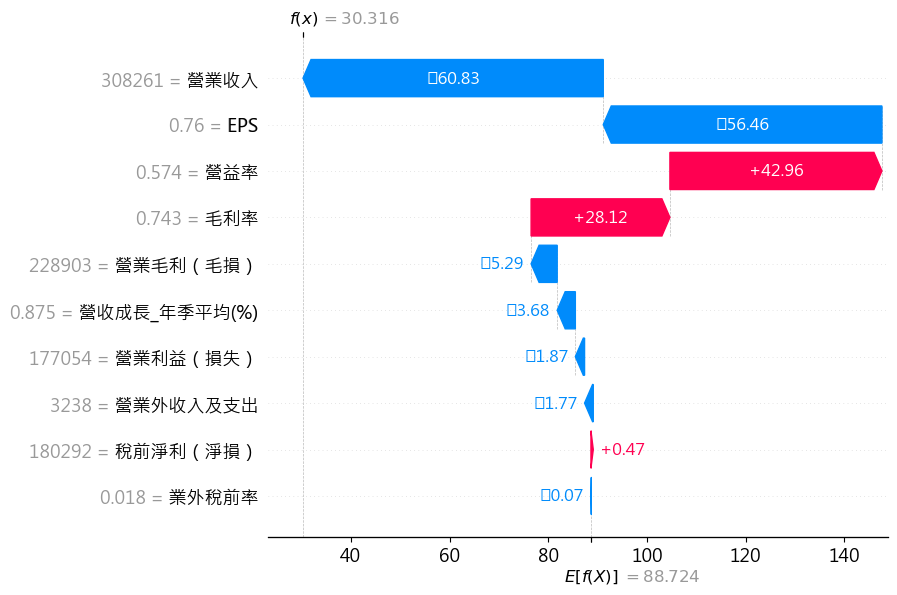

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\1207247677.py:121: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


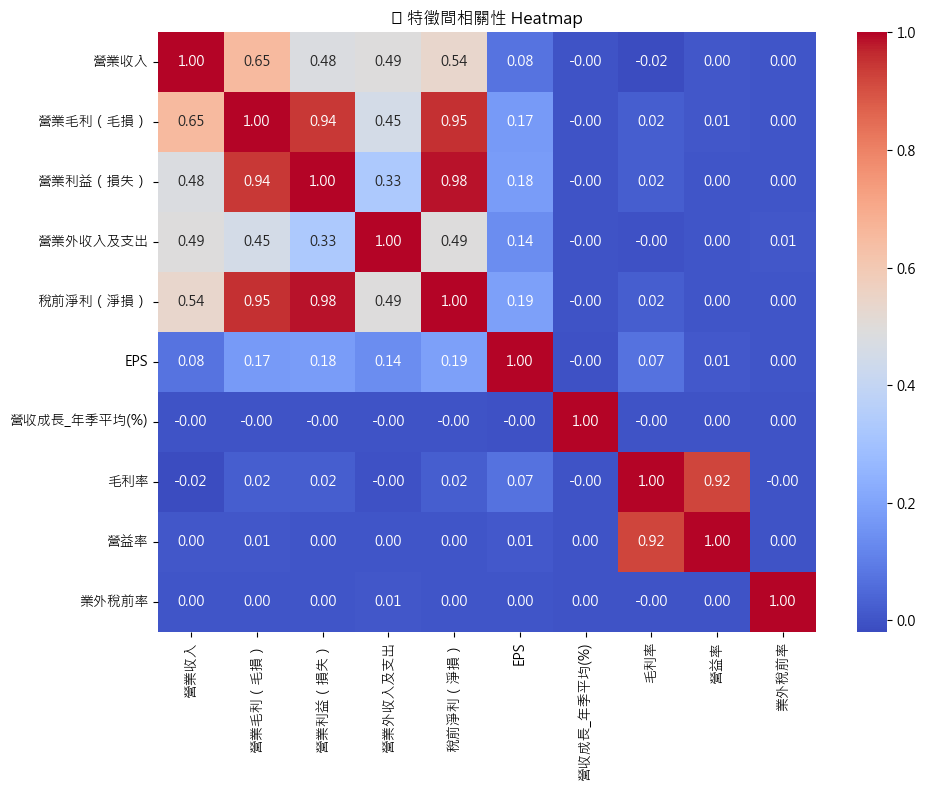

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

# ===== 字型設定（支援中文）=====
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# ===== Step 1：讀取資料 =====
df_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

# ===== Step 2：整理欄位與合併 =====
df_fin = pd.concat([df_sii, df_otc], ignore_index=True)
df_fin['year_quarter'] = df_fin['年季'].astype(str).str.strip()
df_fin['公司代號'] = df_fin['公司代號'].astype(str).str.strip()
df_price['公司代號'] = df_price['公司代號'].astype(str).str.strip()
df_price['year_quarter'] = df_price['year_quarter'].astype(str).str.strip()
df_revenue['公司代號'] = df_revenue['公司代號'].astype(str).str.strip()
df_revenue['year_quarter'] = df_revenue['year_quarter'].astype(str).str.strip()

df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

# EPS 欄位別名補上
df["EPS"] = df["基本每股盈餘（元）"]

# ===== Step 3：設定特徵與目標 =====
target = "季均價"

feature_cols = [
    "營業收入",
    "營業毛利（毛損）",
    "營業利益（損失）",
    "營業外收入及支出",
    "稅前淨利（淨損）",
    "EPS",
    "營收成長_年季平均(%)",
    # ✅ 加入三個額外重要指標
    "營業毛利/營業收入",
    "營業利益/營業收入",
    "營業外收入支出/稅前淨利",
    "毛利率",
    "營益率",
    "業外稅前率"
]

# 避免因缺欄位出錯
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(df[target], errors='coerce')

# ===== Step 4：補值 =====
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

# ===== Step 5：切分資料 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# ===== Step 6：建立 XGBoost 模型 =====
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# ===== Step 7：模型評估 =====
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MSE（均方誤差）: {mse:.4f}")
print(f"📈 R² Score（解釋力）: {r2:.4f}")

# ===== Step 8：Permutation Importance =====
perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.Series(perm_result.importances_mean, index=feature_cols).sort_values()

print("\n🔁 Permutation Importance：")
print(perm_importance)

plt.figure(figsize=(8, 5))
perm_importance.plot(kind='barh', color='salmon')
plt.title("🔁 Permutation Importance")
plt.tight_layout()
plt.show()

# ===== Step 9：SHAP 解釋 =====
print("🧠 計算 SHAP 值中...")
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=10)
plt.title("📌 SHAP Summary：特徵對預測股價的影響")
plt.tight_layout()
plt.show()

print("\n🔍 SHAP 單一樣本解釋（第 0 筆）")
shap.plots.waterfall(shap_values[0], max_display=10)

# ===== Step 10：特徵相關性 Heatmap =====
plt.figure(figsize=(10, 8))
sns.heatmap(X_imputed.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("📌 特徵間相關性 Heatmap")
plt.tight_layout()
plt.show()


SHAP 值的「正負」代表：
正值（+）：這個特徵讓模型「預測變大」
負值（−）：這個特徵讓模型「預測變小」

baseline 是模型在沒有任何特徵資訊下，預測的平均值。
假設 baseline 是 34.5 元
SHAP 瀑布圖最後預測是 52.1 元
那每個特徵的 SHAP 值就代表這個特徵把預測值「往上或往下」推了多少：


❗ 那為什麼你會覺得「正負有時候怪怪的」？
這很正常，有幾種可能原因：

特徵本身與目標的關聯是非線性的

例如 EPS 超高也可能代表公司太熱了要回跌

特徵之間有交互作用（feature interaction）

SHAP 是考慮所有組合的平均貢獻，有時會出現某變數「單看時是正相關，但實際效果為負」

模型學到的規則與我們直覺不一樣

尤其是非線性模型如 XGBoost，可能把某些極端值視為異常



In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import shap

# ===== 字型設定 =====
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option("display.float_format", "{:.3f}".format)  # 小數點統一三位

# ===== Step 1：讀取資料 =====
df_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

# ===== Step 2：資料整併 =====
df_fin = pd.concat([df_sii, df_otc], ignore_index=True)
df_fin['year_quarter'] = df_fin['年季'].astype(str).str.strip()
df_fin['公司代號'] = df_fin['公司代號'].astype(str).str.strip()
df_price['公司代號'] = df_price['公司代號'].astype(str).str.strip()
df_price['year_quarter'] = df_price['year_quarter'].astype(str).str.strip()
df_revenue['公司代號'] = df_revenue['公司代號'].astype(str).str.strip()
df_revenue['year_quarter'] = df_revenue['year_quarter'].astype(str).str.strip()

df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

df["EPS"] = df["基本每股盈餘（元）"]

# ===== Step 3：特徵與目標 =====
target = "季均價"
feature_cols = [
    "營業收入", "營業毛利（毛損）", "營業利益（損失）", "營業外收入及支出", "稅前淨利（淨損）",
    "EPS", "營收成長_年季平均(%)",    
    "毛利率", "營益率", "業外稅前率"
]
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(df[target], errors='coerce')

# ===== Step 4：補值處理 =====
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

# ===== Step 5：切分訓練與測試資料 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# ===== Step 6：XGBoost 建模 =====
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# ===== Step 7：預測與評估 =====
y_pred = model.predict(X_test)
print(f"📊 MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"📈 R² Score: {r2_score(y_test, y_pred):.4f}")

# ===== Step 8：SHAP 分析 =====
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# ===== Step 9：建立 SHAP 表格畫布 =====
shap_df = pd.DataFrame(shap_values.values, columns=[f"SHAP_{col}" for col in X_test.columns])
y_pred_series = pd.Series(y_pred, name="預測季均價", index=X_test.index)

canvas = pd.concat([
    df.reset_index(drop=True).loc[X_test.index, ["公司代號", "year_quarter"]],
    y_pred_series.reset_index(drop=True),
    X_test.reset_index(drop=True),
    shap_df.reset_index(drop=True)
], axis=1)

# ===== Step 10：美觀輸出（部分欄位）=====
cols_to_show = [
    "公司代號", "year_quarter", "預測季均價",
    "EPS", "SHAP_EPS",
    "毛利率", "SHAP_毛利率",
    "營益率", "SHAP_營益率"
]

print("\n📋 前 5 筆 SHAP 解釋表格：")
print(canvas[cols_to_show].head(20).to_string(index=False))

# ===== Step 11（可選）：匯出整份表格 =====
canvas.to_csv("SHAP_解釋表格總表.csv", index=False, encoding="utf-8-sig")
print("\n✅ 已匯出：SHAP_解釋表格總表.csv")



📊 MSE: 2249.8324
📈 R² Score: 0.5133

📋 前 5 筆 SHAP 解釋表格：
公司代號 year_quarter  預測季均價    EPS  SHAP_EPS   毛利率  SHAP_毛利率    營益率  SHAP_營益率
1437       2018Q2    NaN    NaN       NaN   NaN       NaN    NaN       NaN
2484       2017Q2    NaN    NaN       NaN   NaN       NaN    NaN       NaN
2642       2019Q4    NaN    NaN       NaN   NaN       NaN    NaN       NaN
2024       2019Q3    NaN    NaN       NaN   NaN       NaN    NaN       NaN
8261       2017Q4    NaN    NaN       NaN   NaN       NaN    NaN       NaN
5269       2020Q1    NaN    NaN       NaN   NaN       NaN    NaN       NaN
1325       2017Q2 50.385  2.800    -6.878 0.088   -19.505  0.019    -7.519
2227       2019Q4    NaN    NaN       NaN   NaN       NaN    NaN       NaN
3454       2018Q4    NaN    NaN       NaN   NaN       NaN    NaN       NaN
4562       2018Q2    NaN    NaN       NaN   NaN       NaN    NaN       NaN
2421       2018Q1    NaN    NaN       NaN   NaN       NaN    NaN       NaN
3037       2018Q4    NaN    NaN       NaN   

✅ 產生序列樣本數：2256，每筆 shape: (4, 10)
Epoch 1/100


c:\Users\Robby1206\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 52883.4961 - val_loss: 8609.9365
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47971.8906 - val_loss: 7816.3643
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 65719.1328 - val_loss: 7540.3110
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31381.0371 - val_loss: 7349.1938
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57760.5664 - val_loss: 7192.2471
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28972.3516 - val_loss: 7062.4458
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 123263.6875 - val_loss: 6944.1772
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36005.3945 - val_loss: 6851.3843
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51859.8047 - val_loss: 6763.8345
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 60673.1836 - val_loss: 6693.6172
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 67281.5234 - val_loss: 6632.2

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\15805899.py:104: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


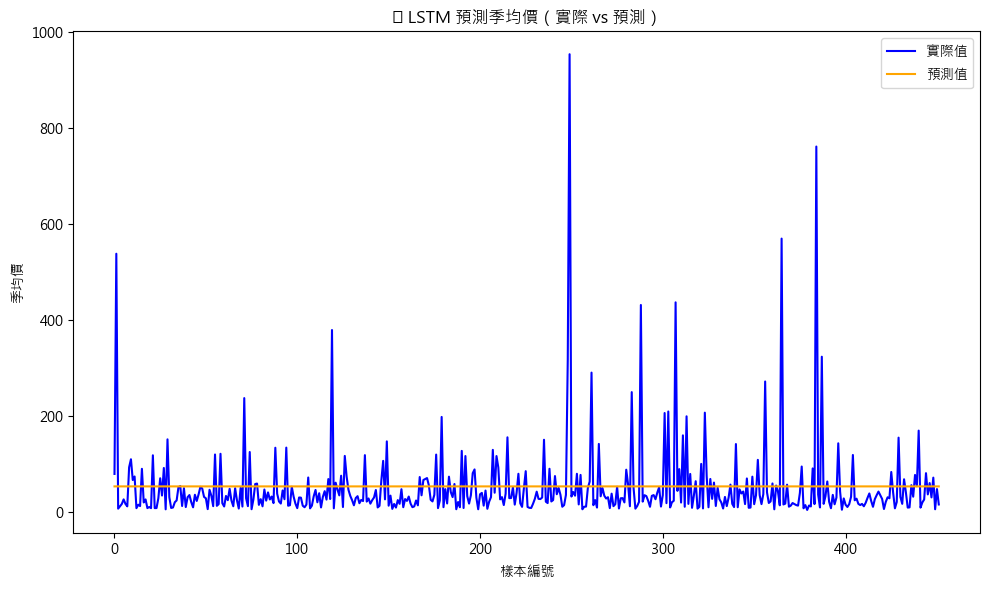


📊 MSE: 7106.6946
📈 R² Score: -0.0010


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ========== Step 1：讀取資料 ==========
df_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

# 清理欄位
for df in [df_sii, df_otc, df_price, df_revenue]:
    df.columns = df.columns.str.strip().str.replace("\ufeff", "")
    df['公司代號'] = df['公司代號'].astype(str).str.strip()

df_fin = pd.concat([df_sii, df_otc], ignore_index=True)
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

# 合併資料
df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

# 建立 EPS 欄位
df["EPS"] = df["基本每股盈餘（元）"]

# ========== Step 2：選擇特徵 ==========
feature_cols = [
    "EPS", "毛利率", "營益率", "業外稅前率",
    "營業收入", "營業毛利（毛損）", "營業利益（損失）",
    "營業外收入及支出", "稅前淨利（淨損）", "營收成長_年季平均(%)"
]
target_col = "季均價"
time_steps = 4

df = df.sort_values(["公司代號", "year_quarter"])

# ========== Step 3：產生 LSTM 時序資料 ==========
X_seq, y_seq = [], []

for stock_id, group in df.groupby("公司代號"):
    group = group.sort_values("year_quarter")
    group = group.dropna(subset=feature_cols + [target_col])

    if len(group) < time_steps + 1:
        continue

    features = group[feature_cols].values
    targets = group[target_col].values

    for i in range(len(group) - time_steps):
        X_seq.append(features[i:i + time_steps])
        y_seq.append(targets[i + time_steps])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"✅ 產生序列樣本數：{X_seq.shape[0]}，每筆 shape: {X_seq.shape[1:]}")

# ========== Step 4：標準化 ==========
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_seq.reshape(-1, X_seq.shape[-1])).reshape(X_seq.shape)

# ========== Step 5：切分資料 ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_seq, test_size=0.2, random_state=42
)

# ========== Step 6：建立 LSTM 模型 ==========
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps, X_seq.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# ========== Step 7：模型訓練 ==========
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ========== Step 8：預測與評估 ==========
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='實際值', color='blue')
plt.plot(y_pred, label='預測值', color='orange')
plt.title("📈 LSTM 預測季均價（實際 vs 預測）")
plt.xlabel("樣本編號")
plt.ylabel("季均價")
plt.legend()
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 MSE: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")


In [41]:
print(df.columns.tolist())

['公司代號', 'year_quarter', '預測季均價', '營業收入', '營業毛利（毛損）', '營業利益（損失）', '營業外收入及支出', '稅前淨利（淨損）', 'EPS', '營收成長_年季平均(%)', '毛利率', '營益率', '業外稅前率', 'SHAP_營業收入', 'SHAP_營業毛利（毛損）', 'SHAP_營業利益（損失）', 'SHAP_營業外收入及支出', 'SHAP_稅前淨利（淨損）', 'SHAP_EPS', 'SHAP_營收成長_年季平均(%)', 'SHAP_毛利率', 'SHAP_營益率', 'SHAP_業外稅前率']


In [35]:
import chardet

with open("SHAP_解釋表格總表.xlsx", "rb") as f:
    raw_data = f.read()  # 讀取整個檔案
    result = chardet.detect(raw_data)
    print("📦 偵測到的編碼：", result)

📦 偵測到的編碼： {'encoding': None, 'confidence': 0.0, 'language': None}


In [34]:
import os

print("檔案大小（bytes）:", os.path.getsize("SHAP_解釋表格總表.xlsx"))

檔案大小（bytes）: 364003


In [26]:
pip install tensorflow

  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.0.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 2.1/376.0 MB 14.7 MB/s eta 0:00:26
    ----------------

Epoch 1/100


c:\Users\Robby1206\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30774.7500 - val_loss: 4081.4272
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31674.2305 - val_loss: 3968.1140
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29087.4160 - val_loss: 3959.3752
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44119.2461 - val_loss: 3947.9141
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38731.0742 - val_loss: 3951.3943
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26496.6074 - val_loss: 3991.8960
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23781.4707 - val_loss: 3956.0264
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48925.4375 - val_loss: 3818.5542
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16958.7520 - val_loss: 3992.2253
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33853.5117 - val_loss: 3850.5449
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29441.611

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\2126317917.py:91: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


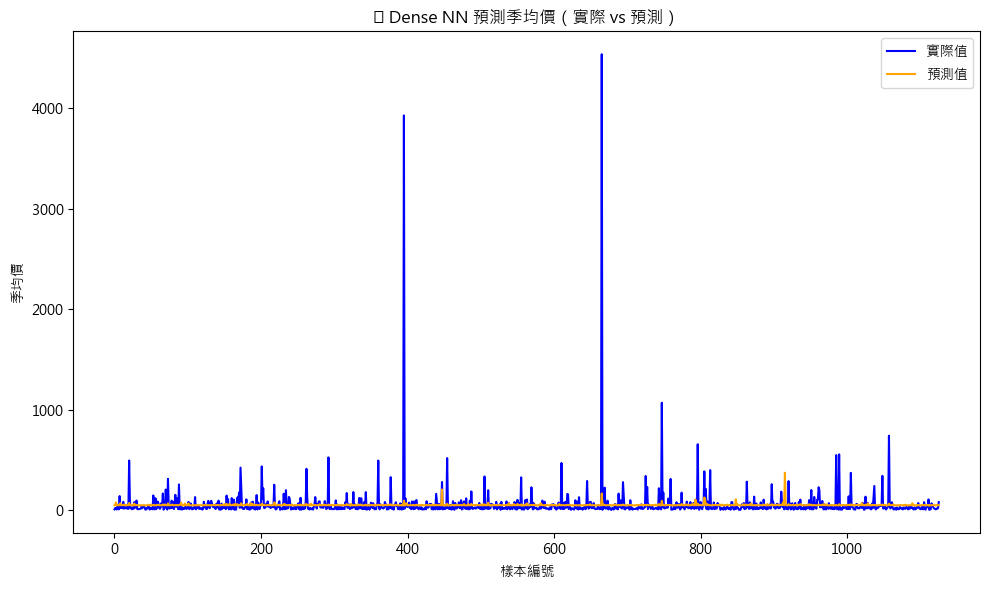

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===== Step 1：讀取與整合資料 =====
df_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

for df in [df_sii, df_otc, df_price, df_revenue]:
    df.columns = df.columns.str.strip().str.replace("\ufeff", "")
    df['公司代號'] = df['公司代號'].astype(str).str.strip()

df_fin = pd.concat([df_sii, df_otc], ignore_index=True)
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

# 合併資料
df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

df["EPS"] = df["基本每股盈餘（元）"]

# ===== Step 2：特徵與目標設定 =====
feature_cols = [
    "EPS", "毛利率", "營益率", "業外稅前率",
    "營業收入", "營業毛利（毛損）", "營業利益（損失）",
    "營業外收入及支出", "稅前淨利（淨損）", "營收成長_年季平均(%)"
]
target_col = "季均價"

df = df.dropna(subset=feature_cols + [target_col])
X = df[feature_cols]
y = df[target_col]

# ===== Step 3：標準化 + 切分資料 =====
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ===== Step 4：建立 Dense NN 模型 =====
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # 輸出預測季均價

model.compile(optimizer='adam', loss='mse')

# ===== Step 5：訓練模型 =====
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ===== Step 6：預測與評估 =====
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 MSE: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===== Step 7：可視化結果 =====
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='實際值', color='blue')
plt.plot(y_pred, label='預測值', color='orange')
plt.title("📈 Dense NN 預測季均價（實際 vs 預測）")
plt.xlabel("樣本編號")
plt.ylabel("季均價")
plt.legend()
plt.tight_layout()
plt.show()



🏷 正在訓練模型：中低價股


c:\Users\Robby1206\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
📊 MSE: 117.5410
📈 R²: 0.1982


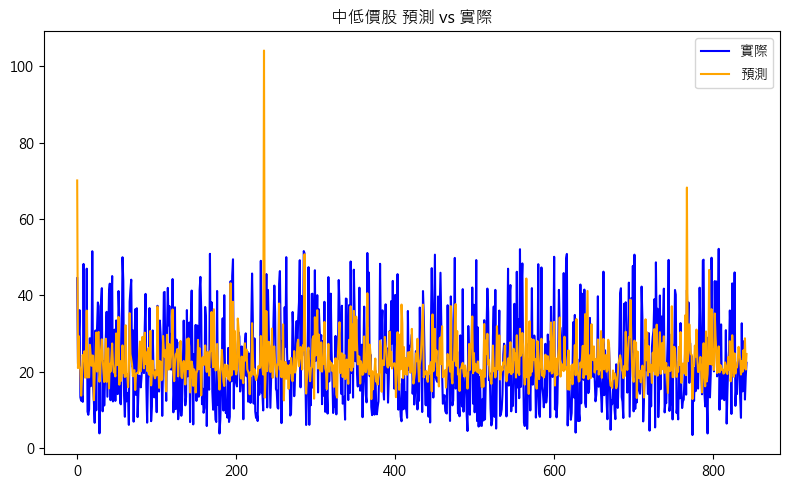


🏷 正在訓練模型：高價股


c:\Users\Robby1206\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
📊 MSE: 16628.9172
📈 R²: -0.0022


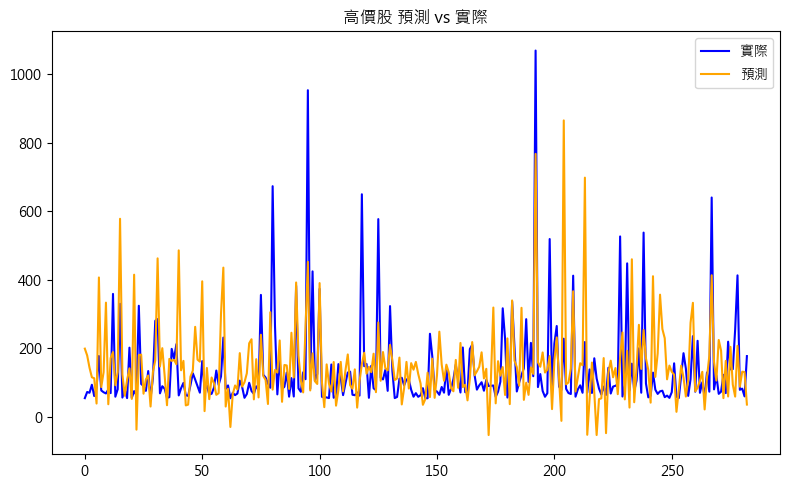

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ====== Step 1：讀取與合併資料 ======
df_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

# 清理主鍵欄位
df_fin = pd.concat([df_sii, df_otc], ignore_index=True)
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()
df_fin["公司代號"] = df_fin["公司代號"].astype(str).str.strip()
df_price["公司代號"] = df_price["公司代號"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()
df_revenue["公司代號"] = df_revenue["公司代號"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

# 合併資料
df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

df["EPS"] = df["基本每股盈餘（元）"]

# ====== Step 2：定義模型函數 ======
def build_dnn_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_and_evaluate(df_subset, label):
    print(f"\n🏷 正在訓練模型：{label}")
    feature_cols = [
        "EPS", "毛利率", "營益率", "業外稅前率",
        "營業收入", "營業毛利（毛損）", "營業利益（損失）",
        "營業外收入及支出", "稅前淨利（淨損）", "營收成長_年季平均(%)"
    ]
    target_col = "季均價"

    df_subset = df_subset.dropna(subset=feature_cols + [target_col])
    X = df_subset[feature_cols]
    y = df_subset[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = build_dnn_model(X_train.shape[1])
    es = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[es], verbose=0)

    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"📊 MSE: {mse:.4f}")
    print(f"📈 R²: {r2:.4f}")

    # 視覺化
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values, label="實際", color='blue')
    plt.plot(y_pred, label="預測", color='orange')
    plt.title(f"{label} 預測 vs 實際")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ====== Step 3：PR75 分群 ======
threshold = df["季均價"].quantile(0.75)
df_high = df[df["季均價"] > threshold].copy()
df_low  = df[df["季均價"] <= threshold].copy()

# ====== Step 4：分別訓練 DNN 模型 ======
train_and_evaluate(df_low, "中低價股")
train_and_evaluate(df_high, "高價股")


c:\Users\Robby1206\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
📊 MSE（還原後）: 12581.2211
📈 R²: 0.2418


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\3273855681.py:69: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


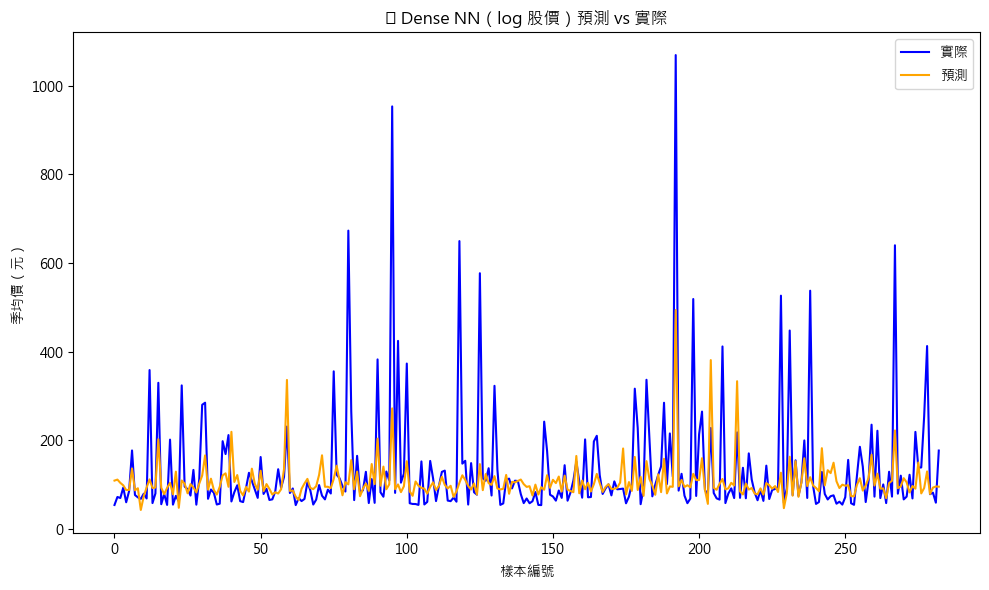

IndexError: positional indexers are out-of-bounds

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===== 1. 選擇分群資料集（df_high 或 df_low）=====
df_target = df_high.copy()  # ← 改成 df_low 看中低價股

# ===== 2. 特徵與目標 =====
feature_cols = [
    "EPS", "毛利率", "營益率", "業外稅前率",
    "營業收入", "營業毛利（毛損）", "營業利益（損失）",
    "營業外收入及支出", "稅前淨利（淨損）", "營收成長_年季平均(%)"
]
target_col = "季均價"

df_target = df_target.dropna(subset=feature_cols + [target_col])
df_target["log_股價"] = np.log1p(df_target[target_col])  # log(1 + 股價)

X = df_target[feature_cols]
y = df_target["log_股價"]

# ===== 3. 標準化特徵 =====
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ===== 4. 切分訓練/測試集 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ===== 5. 建立 DNN 模型 =====
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

# ===== 6. 預測 & 還原 log 股價 =====
y_pred_log = model.predict(X_test).flatten()
y_pred = np.expm1(y_pred_log)  # 反轉 log1p
y_true = np.expm1(y_test)      # 實際值也還原

# ===== 7. 評估模型 =====
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"📊 MSE（還原後）: {mse:.4f}")
print(f"📈 R²: {r2:.4f}")

# ===== 8. 視覺化 =====
plt.figure(figsize=(10, 6))
plt.plot(y_true.values, label="實際", color='blue')
plt.plot(y_pred, label="預測", color='orange')
plt.title("🔍 Dense NN（log 股價）預測 vs 實際")
plt.xlabel("樣本編號")
plt.ylabel("季均價（元）")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 9. 建立結果 DataFrame =====
result_df = df_target.iloc[y_test.index][["公司代號", "公司名稱", "year_quarter"]].copy()
result_df["實際股價"] = y_true.values
result_df["預測股價"] = y_pred
result_df["誤差"] = result_df["預測股價"] - result_df["實際股價"]
result_df["誤差率(%)"] = (result_df["誤差"] / result_df["實際股價"] * 100).round(2)

# ===== 10. 列出誤差最大的公司 =====
print("\n📉 預測誤差最大的前 10 名：")
print(result_df.sort_values(by="誤差率(%)", ascending=False).head(10).to_string(index=False))

# ===== 11. 輸出 CSV =====
result_df.to_csv("高價股_預測結果_debug.csv", index=False, encoding="utf-8-sig")
print("\n✅ 已匯出：高價股_預測結果_debug.csv")


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===== 1. 讀入整併過的資料（包含產業別）=====
df = pd.read_csv("SHAP_解釋表格總表.csv", encoding="utf-8-sig")

# ===== 2. 特徵設定 =====
numerical_cols = [
    "EPS", "毛利率", "營益率", "業外稅前率",
    "營業收入", "營業毛利（毛損）", "營業利益（損失）",
    "營業外收入及支出", "稅前淨利（淨損）", "營收成長_年季平均(%)"
]

target_col = "季均價"

# ===== 3. One-Hot Encoding for 「產業別」 =====
df = df.dropna(subset=numerical_cols + [target_col, "產業別"])
df = pd.get_dummies(df, columns=["產業別"])  # 一鍵變成 one-hot

# ===== 4. 預測目標：log(季均價) =====
df["log_股價"] = np.log1p(df[target_col])

# ===== 5. 準備資料 =====
feature_cols = numerical_cols + [col for col in df.columns if col.startswith("產業別_")]
X = df[feature_cols]
y = df["log_股價"]

# ===== 6. 標準化數值欄位 =====
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ===== 7. 切分資料 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ===== 8. 建立 DNN 模型 =====
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 設定 EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# ===== 9. 預測與還原 =====
y_pred_log = model.predict(X_test).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# ===== 10. 評估模型表現 =====
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"📊 MSE: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===== 11. 視覺化結果 =====
plt.figure(figsize=(10, 6))
plt.plot(y_true.values, label="實際", color='blue')
plt.plot(y_pred, label="預測", color='orange')
plt.title("🏭 DNN 模型（加入產業別）預測 vs 實際")
plt.xlabel("樣本編號")
plt.ylabel("季均價（元）")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 12. 匯出預測誤差表 =====
result_df = df.iloc[y_test.index][["公司代號", "公司名稱", "year_quarter"]].copy()
result_df["實際股價"] = y_true.values
result_df["預測股價"] = y_pred
result_df["誤差"] = result_df["預測股價"] - result_df["實際股價"]
result_df["誤差率(%)"] = (result_df["誤差"] / result_df["實際股價"] * 100).round(2)

# 輸出
result_df.to_csv("DNN_產業別預測結果.csv", index=False, encoding="utf-8-sig")
print("\n✅ 已匯出：DNN_產業別預測結果.csv")

# 列出預測誤差最大的前 10 筆
print("\n📉 誤差最大 Top 10：")
print(result_df.sort_values(by="誤差率(%)", ascending=False).head(10).to_string(index=False))



KeyError: ['季均價', '產業別']

In [52]:
import pandas as pd

# 載入四個檔案（確保欄位統一）
df_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

# 去除欄位空白與 BOM
for df in [df_sii, df_otc, df_price, df_revenue]:
    df.columns = df.columns.str.strip().str.replace("\ufeff", "")

# 整併財報
df_fin = pd.concat([df_sii, df_otc], ignore_index=True)

# 建立主鍵欄位
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()
df_fin["公司代號"] = df_fin["公司代號"].astype(str).str.strip()
df_price["公司代號"] = df_price["公司代號"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()
df_revenue["公司代號"] = df_revenue["公司代號"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

# 合併資料
df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

# 回傳欄位讓我們確認下一步
df.columns.tolist()


['公司代號',
 '公司名稱_x',
 '營業收入',
 '營業毛利（毛損）',
 '營業利益（損失）',
 '營業外收入及支出',
 '稅前淨利（淨損）',
 '基本每股盈餘（元）',
 '毛利率',
 '營益率',
 '業外稅前率',
 '年季',
 'year_quarter',
 '季均價',
 '公司名稱_y',
 '產業別',
 '營業收入-當月營收',
 '營收成長_年季平均(%)']

c:\Users\Robby1206\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MSE: 20643.5979
📈 R² Score: 0.4460


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_21852\1399934323.py:103: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


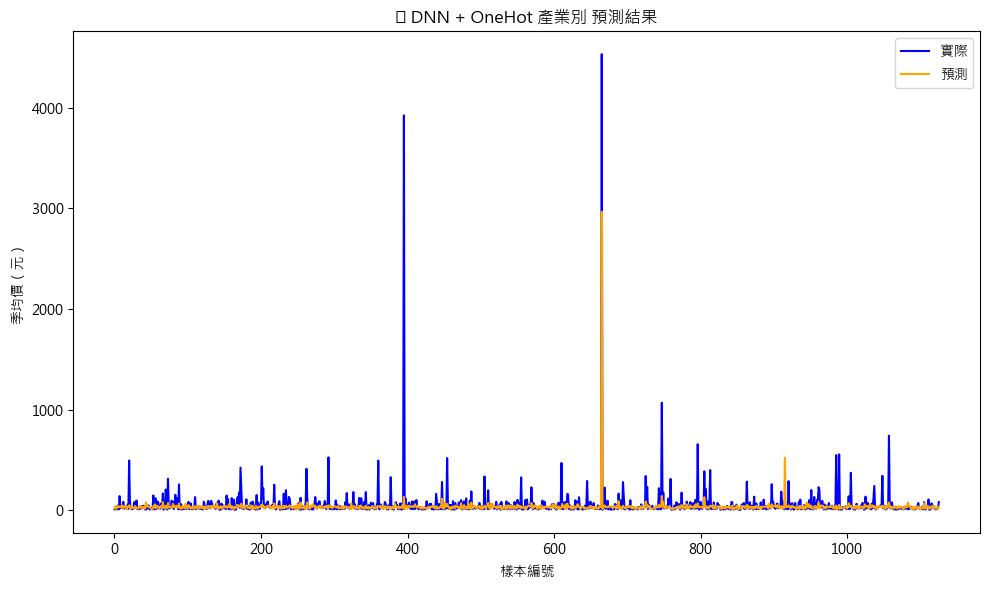

IndexError: positional indexers are out-of-bounds

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===== Step 1：讀取四個檔案 =====
df_sii = pd.read_csv("MOPS_第3表格sii_總表.csv", encoding="utf-8-sig")
df_otc = pd.read_csv("MOPS_第2表格otc_總表.csv", encoding="utf-8-sig")
df_price = pd.read_csv("quarterly_avg_price.csv", encoding="utf-8-sig")
df_revenue = pd.read_csv("quarterly_revenue_cleaned.csv", encoding="utf-8-sig")

# ===== Step 2：整合資料與清洗欄位 =====
for df in [df_sii, df_otc, df_price, df_revenue]:
    df.columns = df.columns.str.strip().str.replace("\ufeff", "")

df_fin = pd.concat([df_sii, df_otc], ignore_index=True)
df_fin["year_quarter"] = df_fin["年季"].astype(str).str.strip()
df_fin["公司代號"] = df_fin["公司代號"].astype(str).str.strip()
df_price["公司代號"] = df_price["公司代號"].astype(str).str.strip()
df_price["year_quarter"] = df_price["year_quarter"].astype(str).str.strip()
df_revenue["公司代號"] = df_revenue["公司代號"].astype(str).str.strip()
df_revenue["year_quarter"] = df_revenue["year_quarter"].astype(str).str.strip()

df = df_fin.merge(df_price, on=["公司代號", "year_quarter"], how="inner") \
           .merge(df_revenue, on=["公司代號", "year_quarter"], how="left")

# ===== Step 3：指定特徵與目標欄位 =====
df["EPS"] = df["基本每股盈餘（元）"]

numerical_cols = [
    "EPS", "毛利率", "營益率", "業外稅前率",
    "營業收入", "營業毛利（毛損）", "營業利益（損失）",
    "營業外收入及支出", "稅前淨利（淨損）", "營收成長_年季平均(%)"
]

target_col = "季均價"

# ===== Step 4：清理欄位與 One-Hot 編碼「產業別」=====
df.columns = df.columns.str.strip()
df = df.dropna(subset=numerical_cols + [target_col, "產業別"])
df = pd.get_dummies(df, columns=["產業別"])

# ===== Step 5：建立特徵與目標 =====
df["log_股價"] = np.log1p(df[target_col])
feature_cols = numerical_cols + [col for col in df.columns if col.startswith("產業別_")]

X = df[feature_cols]
y = df["log_股價"]

# ===== Step 6：MinMax 標準化數值 =====
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ===== Step 7：切分資料 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ===== Step 8：建立 DNN 模型 =====
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# ===== Step 9：預測還原 & 評估 =====
y_pred_log = model.predict(X_test).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📊 MSE: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===== Step 10：視覺化結果 =====
plt.figure(figsize=(10, 6))
plt.plot(y_true.values, label="實際", color='blue')
plt.plot(y_pred, label="預測", color='orange')
plt.title("🏭 DNN + OneHot 產業別 預測結果")
plt.xlabel("樣本編號")
plt.ylabel("季均價（元）")
plt.legend()
plt.tight_layout()
plt.show()

# ===== Step 11：誤差輸出表格 =====
result_df = df.iloc[y_test.index][["公司代號", "公司名稱_x", "year_quarter"]].copy()
result_df = result_df.rename(columns={"公司名稱_x": "公司名稱"})
result_df["實際股價"] = y_true.values
result_df["預測股價"] = y_pred
result_df["誤差"] = result_df["預測股價"] - result_df["實際股價"]
result_df["誤差率(%)"] = (result_df["誤差"] / result_df["實際股價"] * 100).round(2)

# ===== Step 12：輸出 & 列出 top10 =====
result_df.to_csv("DNN_產業別預測結果.csv", index=False, encoding="utf-8-sig")
print("\n✅ 已匯出：DNN_產業別預測結果.csv")
print("\n📉 預測誤差最大 Top 10：")
print(result_df.sort_values(by="誤差率(%)", ascending=False).head(10).to_string(index=False))
